In [1]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
import openai
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.datasets import OxfordIIITPet
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchmetrics
from torch.utils.data import DataLoader, Subset
from torch.nn import functional as F
import logging
import clip
import json
openai.api_key  = os.getenv('OPENAI_API_KEY')
from collections import OrderedDict
import numpy as np
from tqdm import tqdm

# Load Dataset using the Mean and std dev of training dataset

In [17]:
oxfordpet_path = '/home/kush/Desktop/CLIP/'
transform = transforms.Compose([
    transforms.Resize(224, interpolation=Image.BICUBIC),
    transforms.CenterCrop(224),
    lambda image: image.convert("RGB"),
    transforms.ToTensor(),
    transforms.Normalize((0.4827, 0.4472, 0.3974), (0.2289, 0.2260, 0.2275)),
])
oxfordpet_dataset_train = OxfordIIITPet(oxfordpet_path, split="trainval", transform = transform)
oxfordpet_dataset_test = OxfordIIITPet(oxfordpet_path, split="test", transform = transform)

# Change Class names -> They are not proper

In [3]:
def get_full_class_labels(file_path):
    classes_full_names = set()
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            class_id, _, species, _ = line.strip('\n').split(' ', 3)
            class_id = ' '.join(class_id.split('_')[0: -1]).title()
            if int(species) == 1:
                class_id += ' Cat'
            else:
                class_id += ' Dog'
            classes_full_names.add(class_id)
    return classes_full_names

In [4]:
def fix_class_names(dataset, complete_class_names):
    for class_name in complete_class_names:
        incomplete_class_name = ' '.join(class_name.split(' ')[0: -1]).strip()
        find_index = lambda l, x: l.index(x) if x in l else -1
        index_of_incorrect_class = find_index(dataset.classes, incomplete_class_name)
        if index_of_incorrect_class != -1:
            dataset.classes[index_of_incorrect_class] = class_name
        idx = dataset.class_to_idx.pop(incomplete_class_name, -1)
        if idx != -1:
            dataset.class_to_idx[class_name] = idx

In [5]:
list_txt_path = 'oxford-iiit-pet/annotations/list.txt'
full_class_labels = get_full_class_labels(os.path.join(oxfordpet_path,list_txt_path))
fix_class_names(oxfordpet_dataset_train, full_class_labels)
fix_class_names(oxfordpet_dataset_test, full_class_labels)
print(oxfordpet_dataset_train.classes)
print(oxfordpet_dataset_train.class_to_idx)

['Abyssinian Cat', 'American Bulldog Dog', 'American Pit Bull Terrier Dog', 'Basset Hound Dog', 'Beagle Dog', 'Bengal Cat', 'Birman Cat', 'Bombay Cat', 'Boxer Dog', 'British Shorthair Cat', 'Chihuahua Dog', 'Egyptian Mau Cat', 'English Cocker Spaniel Dog', 'English Setter Dog', 'German Shorthaired Dog', 'Great Pyrenees Dog', 'Havanese Dog', 'Japanese Chin Dog', 'Keeshond Dog', 'Leonberger Dog', 'Maine Coon Cat', 'Miniature Pinscher Dog', 'Newfoundland Dog', 'Persian Cat', 'Pomeranian Dog', 'Pug Dog', 'Ragdoll Cat', 'Russian Blue Cat', 'Saint Bernard Dog', 'Samoyed Dog', 'Scottish Terrier Dog', 'Shiba Inu Dog', 'Siamese Cat', 'Sphynx Cat', 'Staffordshire Bull Terrier Dog', 'Wheaten Terrier Dog', 'Yorkshire Terrier Dog']
{'Pomeranian Dog': 24, 'Russian Blue Cat': 27, 'Wheaten Terrier Dog': 35, 'Abyssinian Cat': 0, 'Great Pyrenees Dog': 15, 'Keeshond Dog': 18, 'Japanese Chin Dog': 17, 'Staffordshire Bull Terrier Dog': 34, 'Pug Dog': 25, 'Boxer Dog': 8, 'Saint Bernard Dog': 28, 'Chihuahua 

# Load model

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device=device, jit=False)
model = model.eval()
model = model.requires_grad_(False)

# Function for computing Label text emebddings

In [19]:
def compute_encodings(model, labels):
    label_encodings = F.normalize(model.encode_text(clip.tokenize(labels).to(device)))
    return label_encodings

In [20]:
def compute_descriptions_encodings(model, desc_dict):
    desc_enc_dict = dict()
    for i, (k, v) in enumerate(desc_dict.items()):
        v = map(lambda x: f"{k}, {x}", v)
        desc_enc_dict[k] = compute_encodings(model, v)
    return desc_enc_dict

# Function for index to label

In [21]:
def idx_to_label(label_to_idx):
    dataset_items = list(label_to_idx.items())
    return dict(map(lambda x: x[::-1], dataset_items))

In [22]:
def initialize_counter_dict(labels):
    dict_ = dict()
    for label1 in labels:
        dict_[label1] = dict()
        for label2 in labels:
            dict_[label1][label2] = 0
    return dict_

In [23]:
def increase_count(counter_dict, actual_class, top_classes):
    for class_ in top_classes:
        counter_dict[actual_class][class_] += 1
    return counter_dict

In [24]:
def add_to_counter_dict(counter_dict, index_to_class_dict, actual_index_list, 
                        pred_index_list):
    for idx, actual_class_index in enumerate(actual_index_list):
        actual_class = index_to_class_dict[int(actual_class_index)]
        top_classes = list(map(lambda x: index_to_class_dict[int(x)], 
                               pred_index_list[idx].squeeze()))
        counter_dict = increase_count(counter_dict, actual_class, top_classes)
    return counter_dict

In [25]:
def load_json(filename):
    if not filename.endswith('.json'):
        filename += '.json'
    with open(filename, 'r') as fp:
        return json.load(fp)

In [26]:
def ordered_classes(dict_, classes_list):
    ordered_dict = OrderedDict()
    for class_ in classes_list:
        ordered_dict[class_] = list(set(dict_[class_]))
    return ordered_dict

In [27]:
def aggregate_similarity(similarity_matrix_chunk, activations = None, aggregation_method='mean'):
    if aggregation_method == 'max': return similarity_matrix_chunk.max(dim=1)[0]
    elif aggregation_method == 'sum': return similarity_matrix_chunk.sum(dim=1)
    elif aggregation_method == 'mean': return similarity_matrix_chunk.mean(dim=1)
    elif aggregation_method == 'weighted_sum' and activations != None: 
        similarity_matrix_chunk = similarity_matrix_chunk * activations
        return aggregate_similarity(similarity_matrix_chunk, activations, 'sum')
    else: raise ValueError("Unknown aggregate_similarity")


# Calculate CLIP accuracy

In [28]:
def calc_acc(model, dataset, classes, batch_size = 64, 
             topK = 5, desc_loc = 'descriptors/descriptors_pets_top5.json'):
    
    count_classes_dict = initialize_counter_dict(dataset.classes)
    index_to_class_dict = idx_to_label(dataset.class_to_idx)
    descriptions_dict = ordered_classes(load_json(desc_loc), dataset.classes)
    activations_dict = dict()
    n_classes = len(dataset.classes)
    
    label_encodings = compute_encodings(model, dataset.classes)
    description_encodings = compute_descriptions_encodings(model, descriptions_dict)
    clip_accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=len(dataset.classes)).to(device)
    clip_accuracy_metric_top5 = torchmetrics.Accuracy(top_k=5, task="multiclass", num_classes=len(dataset.classes)).to(device)
   
    
    lang_accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=n_classes).to(device)
    lang_accuracy_metric_top5 = torchmetrics.Accuracy(top_k=5, task="multiclass", num_classes=n_classes).to(device)


    dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=16, pin_memory=True)
    
    print(description_encodings.keys())
    
    for batch_number, batch in enumerate(tqdm(dataloader)):
        images, labels = batch

        images = images.to(device)
        labels = labels.to(device)

        image_encodings = model.encode_image(images)
        image_encodings = F.normalize(image_encodings)

        image_labels_similarity = image_encodings @ label_encodings.T
        top5_values, top5_indices = image_labels_similarity.topk(5, dim=1)
        clip_predictions = image_labels_similarity.argmax(dim=1)


        clip_acc = clip_accuracy_metric(image_labels_similarity, labels)
        clip_acc_top5 = clip_accuracy_metric_top5(image_labels_similarity, labels)
        
        
        image_description_similarity = [None]*n_classes
        image_description_similarity_cumulative = [None]*n_classes
        
        for i, (k, v) in enumerate(description_encodings.items()): # You can also vectorize this; it wasn't much faster for me
            
            
            dot_product_matrix = image_encodings @ v.T
            
            image_description_similarity[i] = dot_product_matrix
            image_description_similarity_cumulative[i] = aggregate_similarity(image_description_similarity[i])
#             print(f"image_description_similarity_cumulative[i].size(): {image_description_similarity_cumulative[i].size()}")
            
        # create tensor of similarity means
        cumulative_tensor = torch.stack(image_description_similarity_cumulative,dim=1)
        
        
        descr_predictions = cumulative_tensor.argmax(dim=1)
        
        
        lang_acc = lang_accuracy_metric(cumulative_tensor.softmax(dim=-1), labels)
        lang_acc_top5 = lang_accuracy_metric_top5(cumulative_tensor.softmax(dim=-1), labels)
        
        
        for index, label in enumerate(labels):
            label, pred_label = int(label), int(descr_predictions[index])
            if label == pred_label:
                # Use this activation
                class_name = index_to_class_dict[label]
                activation = image_encodings[index] @ description_encodings[class_name].T
                if class_name in activations_dict:
                    activations_dict[class_name].append(activation)
                else:
                    activations_dict[class_name] = [activation]
        
        
        lang_acc = lang_accuracy_metric(cumulative_tensor.softmax(dim=-1), labels)
        lang_acc_top5 = lang_accuracy_metric_top5(cumulative_tensor.softmax(dim=-1), labels)
            
        


    accuracy_logs = {}
    
    accuracy_logs["Total Description-based Top-1 Accuracy: "] = 100*lang_accuracy_metric.compute().item()
    accuracy_logs["Total Description-based Top-5 Accuracy: "] = 100*lang_accuracy_metric_top5.compute().item()
    
    accuracy_logs["Total CLIP-Standard Top-1 Accuracy: "] = 100*clip_accuracy_metric.compute().item()
    accuracy_logs["Total CLIP-Standard Top-5 Accuracy: "] = 100*clip_accuracy_metric_top5.compute().item()
    
    for k, v in activations_dict.items():
        sum_of_activations = torch.sum(torch.stack(activations_dict[k],dim=1), dim=1).squeeze(dim=-1)
        activations_dict[k] = sum_of_activations.softmax(dim=-1).tolist()

#     print(activations_dict)
    json_string_act = json.dumps(activations_dict, indent=4)  # indent for pretty formatting
    json_string_desc = json.dumps(descriptions_dict, indent=4)  # indent for pretty formatting

    # Write JSON string to a text file
    with open(f'pets_activations.json', 'w') as file:
        file.write(json_string_act)
        
    with open(f'descriptors_pets_top5.json', 'w') as file:
        file.write(json_string_desc)

    
    return accuracy_logs

In [29]:
calc_acc(model, oxfordpet_dataset_train, oxfordpet_dataset_train.classes)

dict_keys(['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair', 'Chihuahua', 'Egyptian Mau', 'English Cocker Spaniel', 'English Setter', 'German Shorthaired', 'Great Pyrenees', 'Havanese', 'Japanese Chin', 'Keeshond', 'Leonberger', 'Maine Coon', 'Miniature Pinscher', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian Blue', 'Saint Bernard', 'Samoyed', 'Scottish Terrier', 'Shiba Inu', 'Siamese', 'Sphynx', 'Staffordshire Bull Terrier', 'Wheaten Terrier', 'Yorkshire Terrier'])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:18<00:00,  3.20it/s]


{'Total Description-based Top-1 Accuracy: ': 80.73369860649109,
 'Total Description-based Top-5 Accuracy: ': 98.9402174949646,
 'Total CLIP-Standard Top-1 Accuracy: ': 76.38586759567261,
 'Total CLIP-Standard Top-5 Accuracy: ': 95.48913240432739}

In [43]:
oxfordpet_dataset_train.classes

['Abyssinian Cat',
 'American Bulldog Dog',
 'American Pit Bull Terrier Dog',
 'Basset Hound Dog',
 'Beagle Dog',
 'Bengal Cat',
 'Birman Cat',
 'Bombay Cat',
 'Boxer Dog',
 'British Shorthair Cat',
 'Chihuahua Dog',
 'Egyptian Mau Cat',
 'English Cocker Spaniel Dog',
 'English Setter Dog',
 'German Shorthaired Dog',
 'Great Pyrenees Dog',
 'Havanese Dog',
 'Japanese Chin Dog',
 'Keeshond Dog',
 'Leonberger Dog',
 'Maine Coon Cat',
 'Miniature Pinscher Dog',
 'Newfoundland Dog',
 'Persian Cat',
 'Pomeranian Dog',
 'Pug Dog',
 'Ragdoll Cat',
 'Russian Blue Cat',
 'Saint Bernard Dog',
 'Samoyed Dog',
 'Scottish Terrier Dog',
 'Shiba Inu Dog',
 'Siamese Cat',
 'Sphynx Cat',
 'Staffordshire Bull Terrier Dog',
 'Wheaten Terrier Dog',
 'Yorkshire Terrier Dog']

# Graphs

In [16]:
def create_graph(actual_label, top5_pred):
    top5labels = list(map(lambda x: x[0], top5_pred))
    top5counts = list(map(lambda x: x[1], top5_pred))
    colors = ['royalblue' if label == actual_label else 'lightsteelblue' for label in top5labels]
    plt.barh(top5labels, top5counts, color=colors)

    num_ticks = 6  # Adjust the number of ticks as needed
    tick_positions = np.linspace(0, max(top5counts), num_ticks)
    plt.xticks(tick_positions, rotation=45, ha='right')  # Set the rotation and horizontal alignment

    plt.xlabel('Top-5 counts')
    plt.ylabel('Classes')
    plt.title('Score-wise Diagram')
    
    # Show the plot
    plt.show()


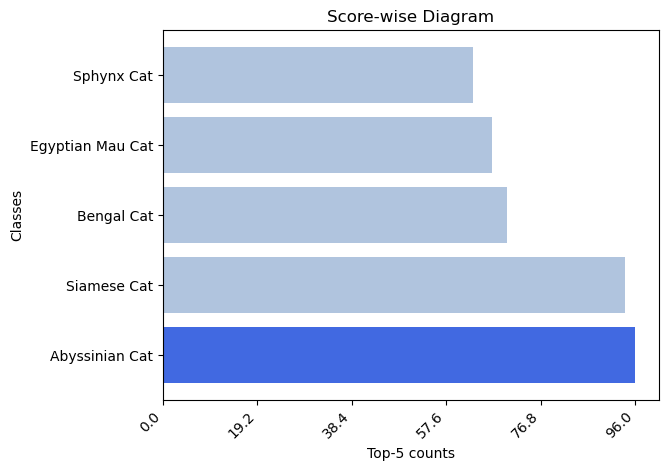

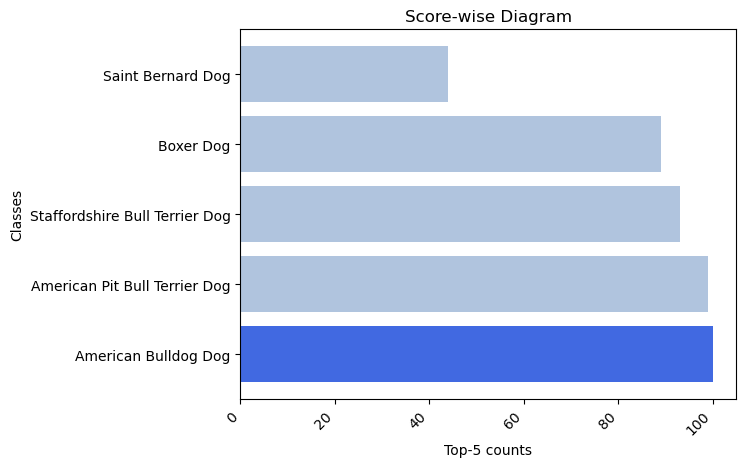

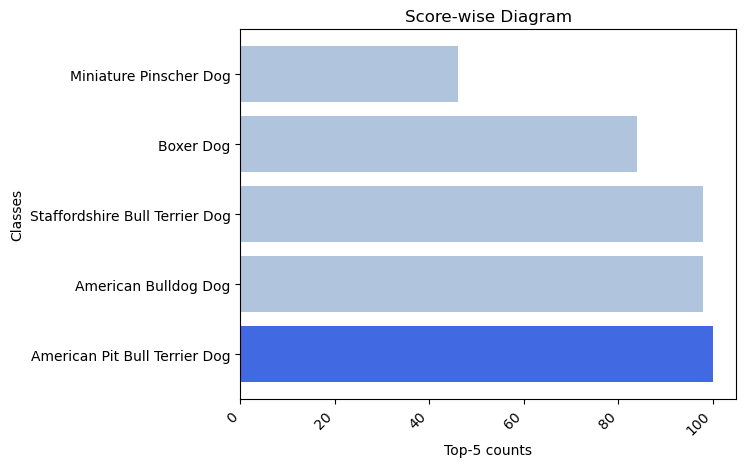

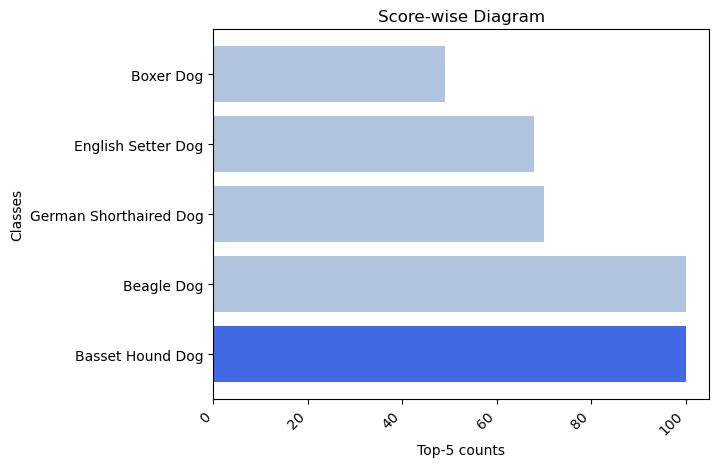

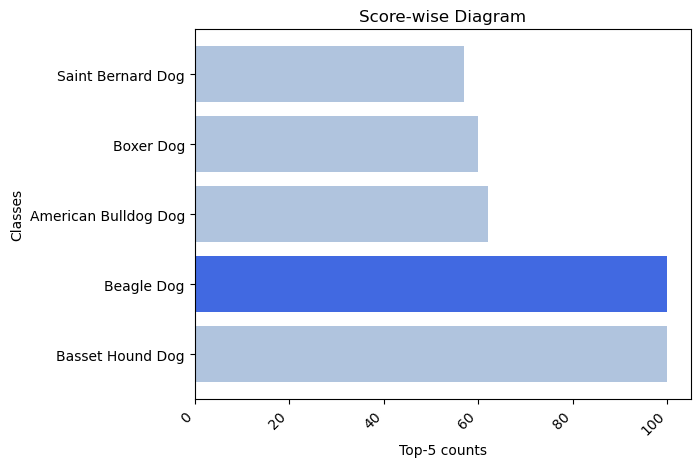

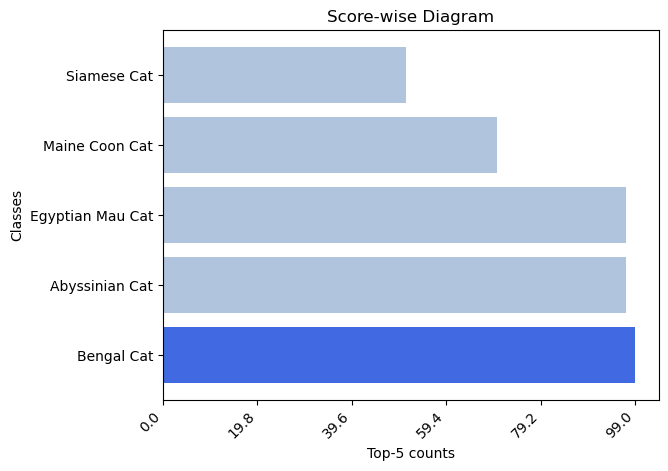

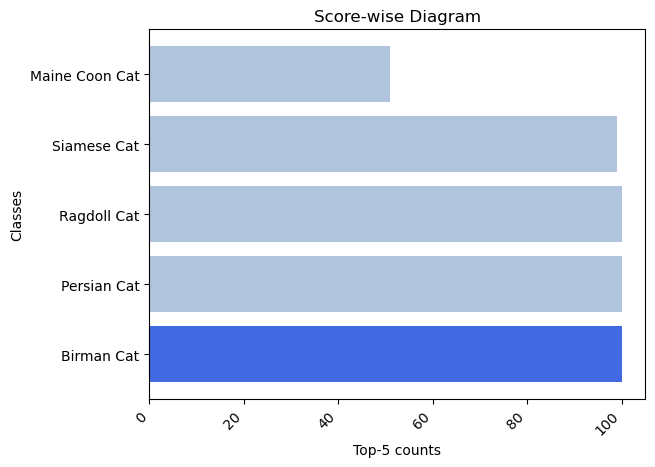

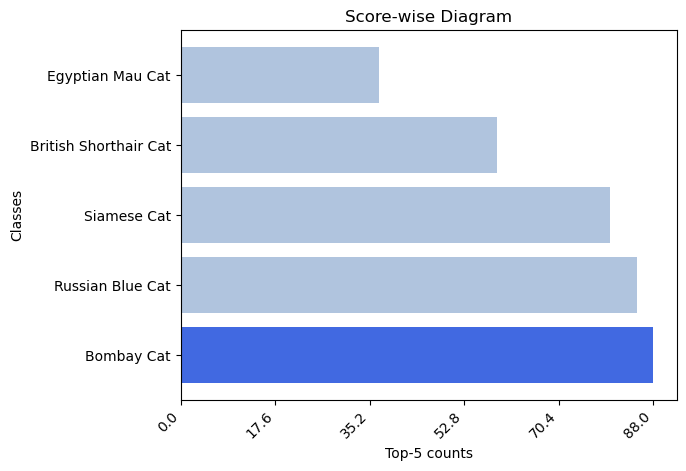

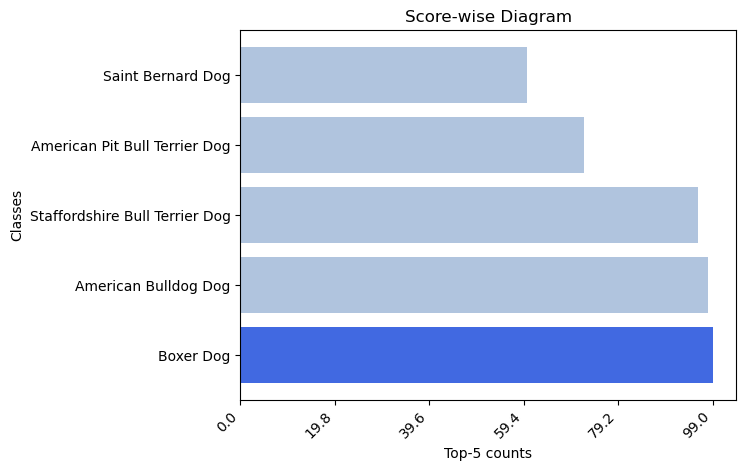

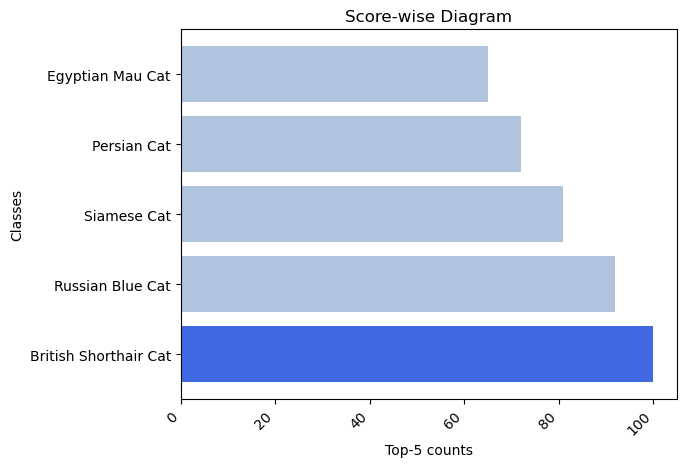

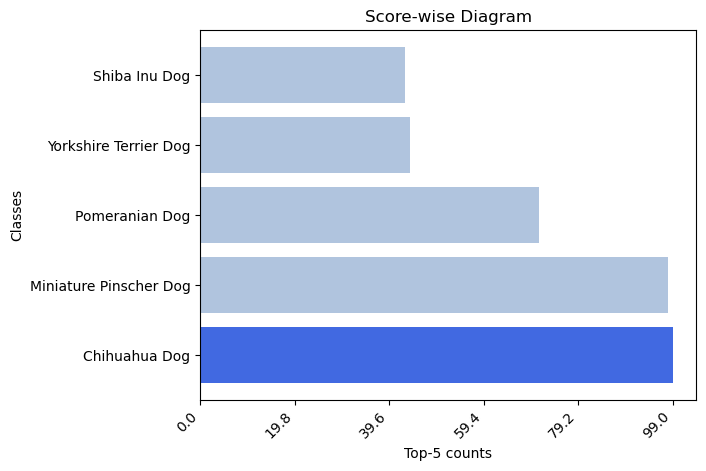

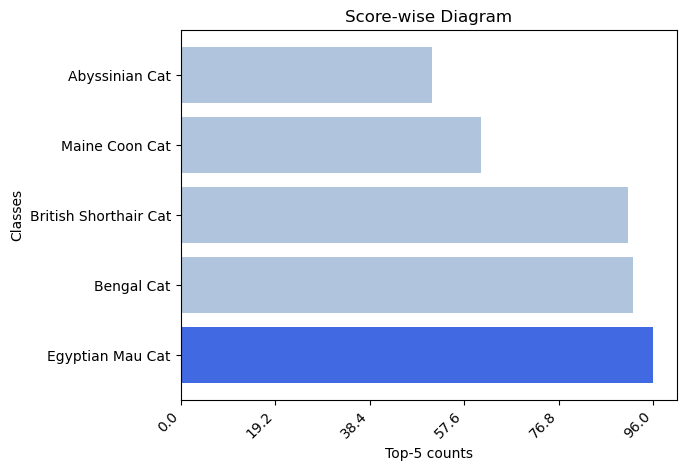

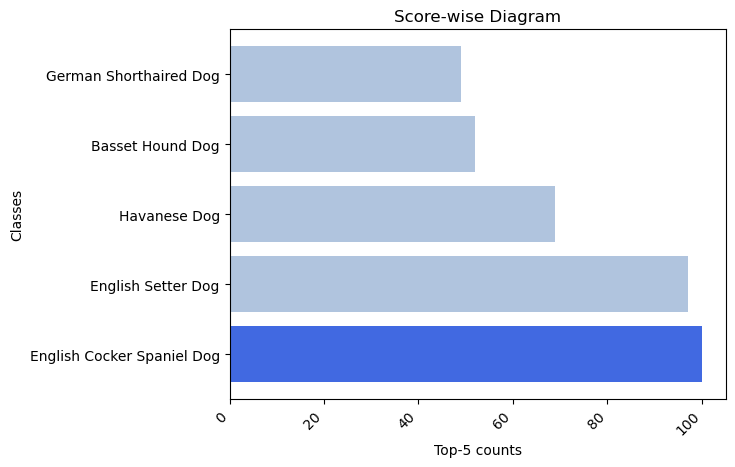

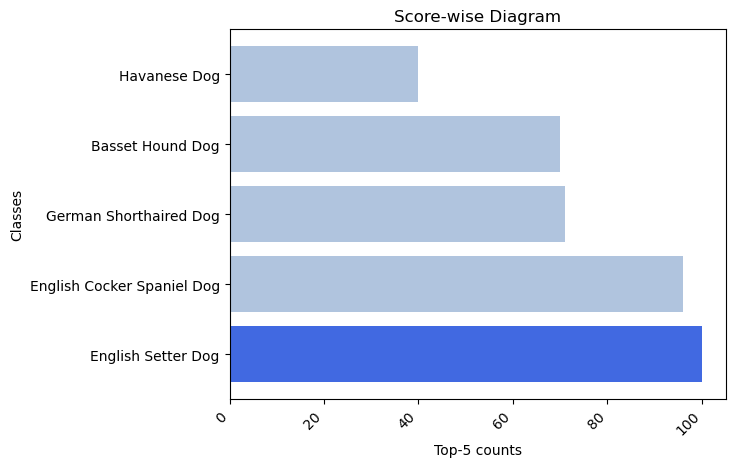

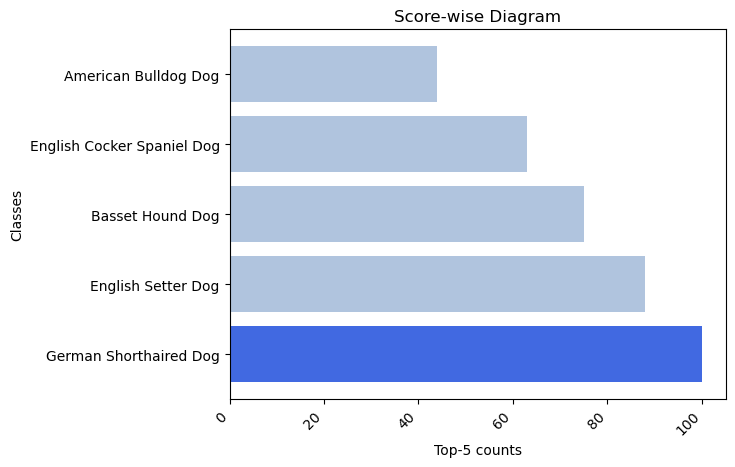

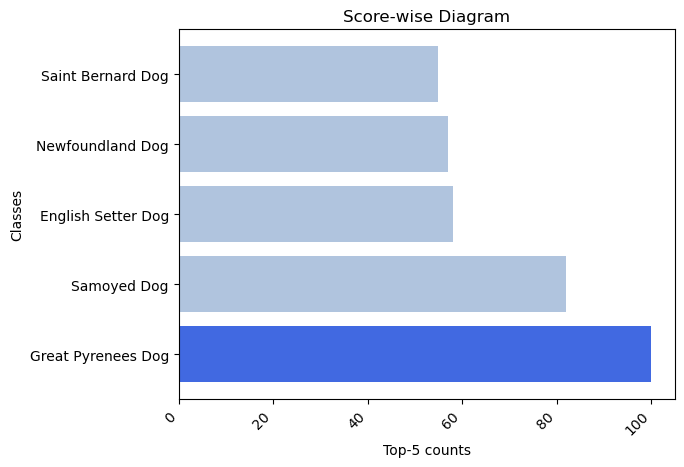

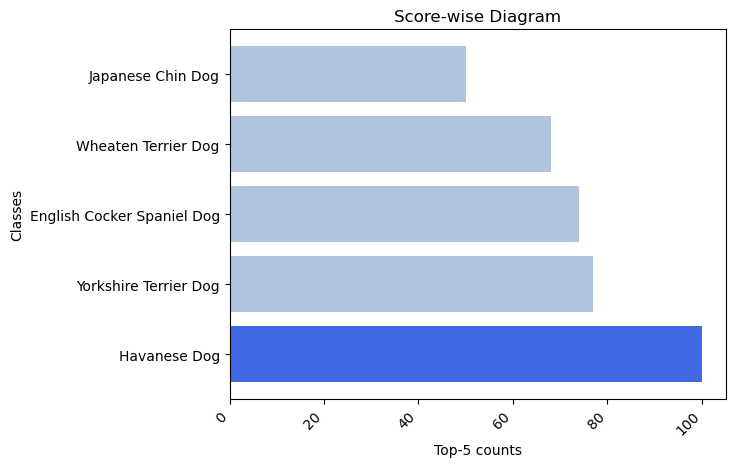

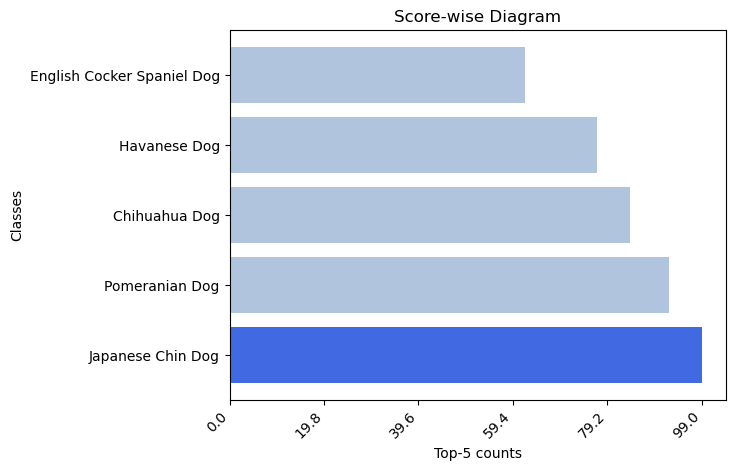

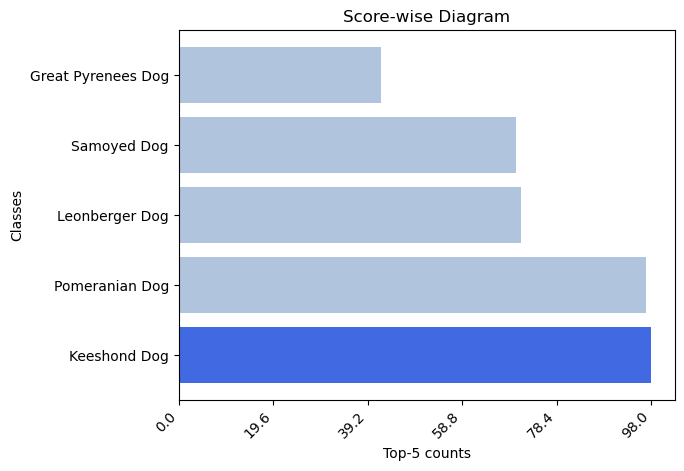

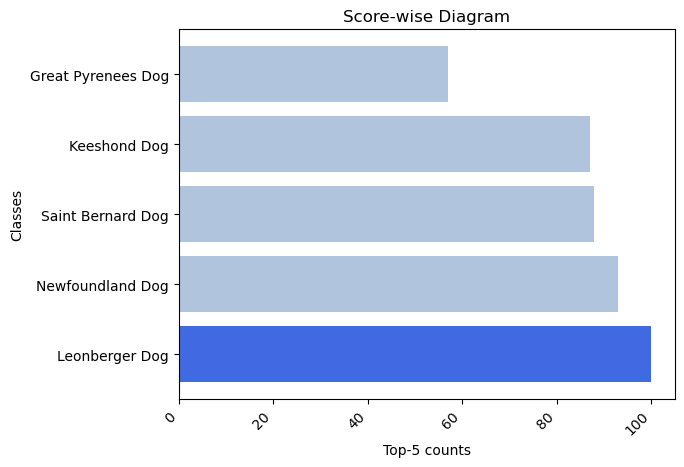

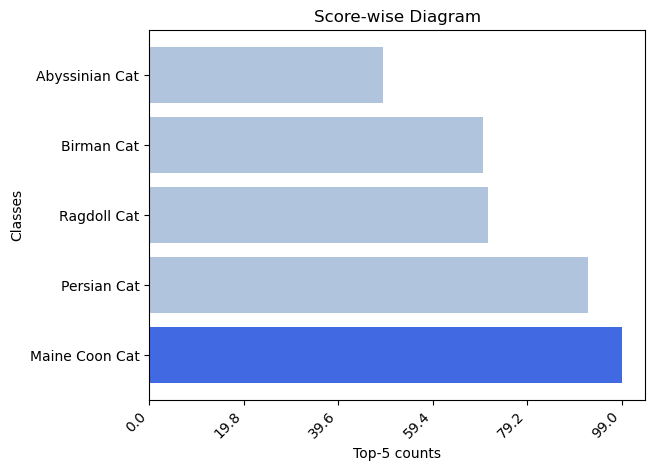

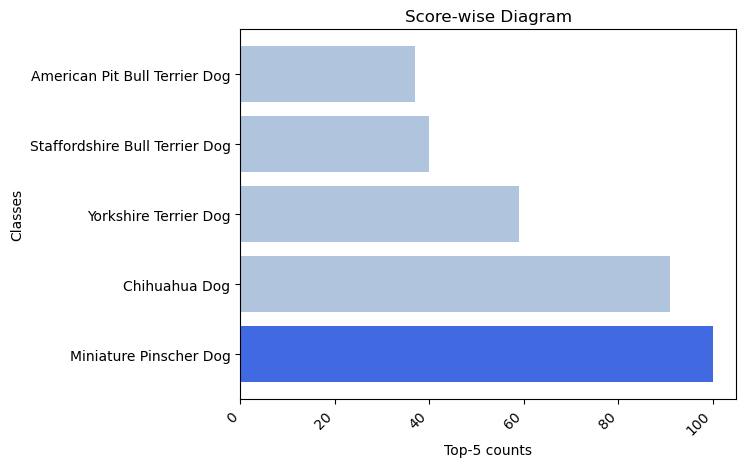

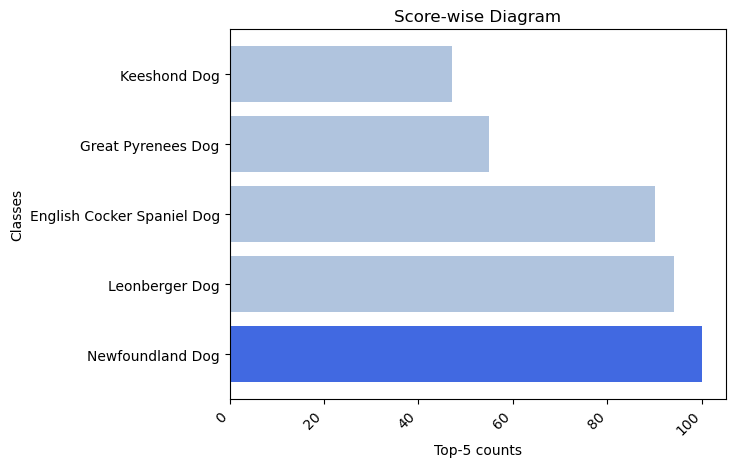

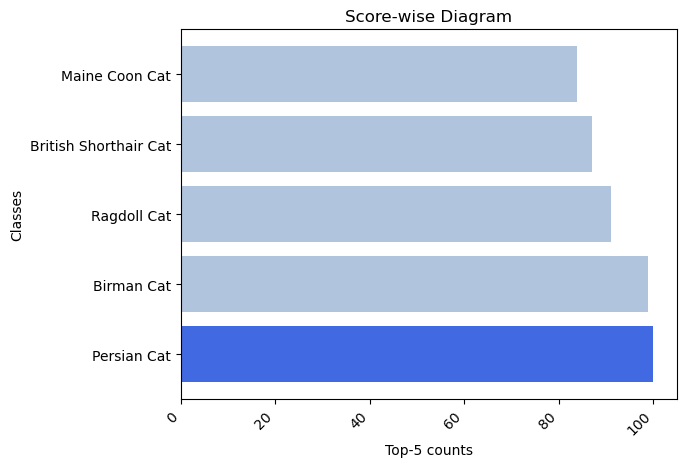

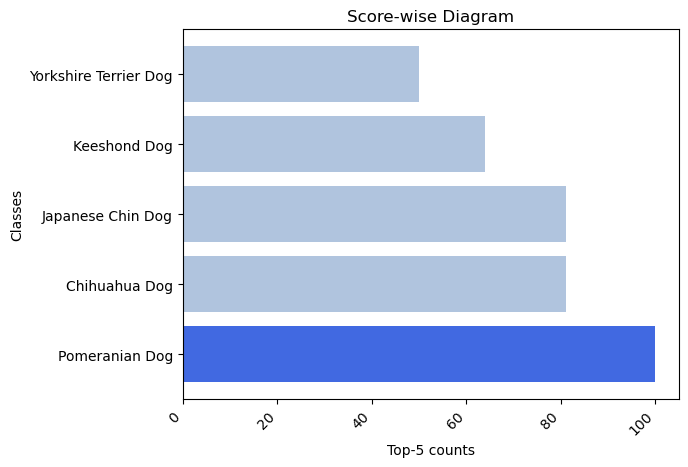

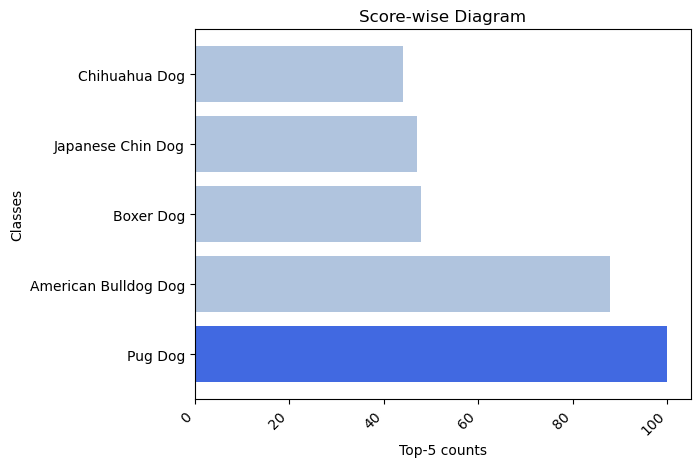

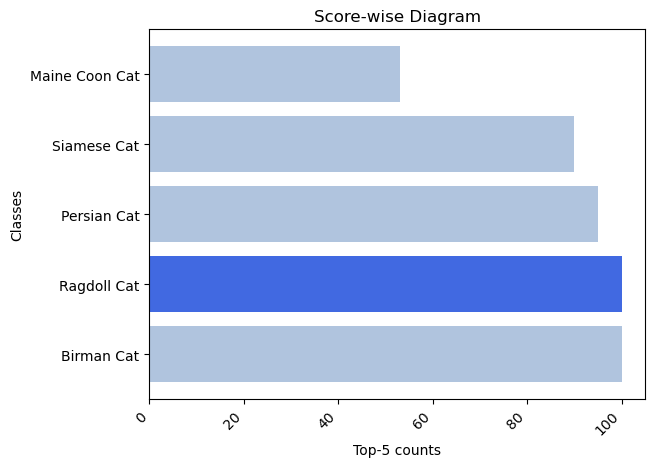

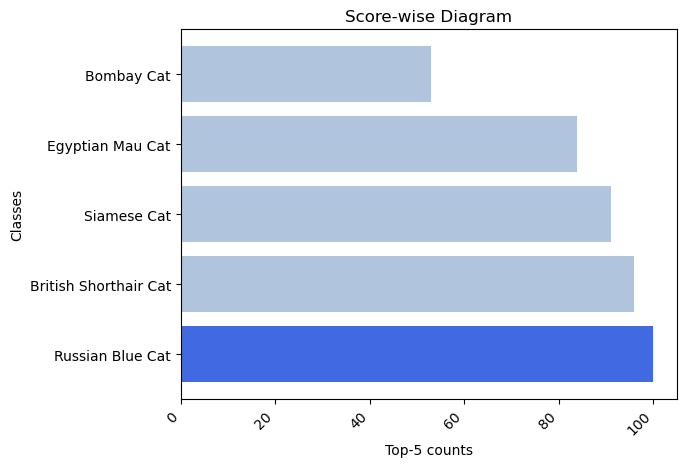

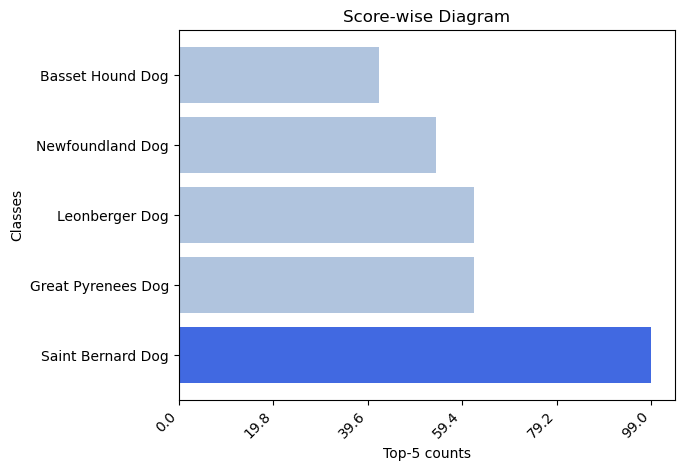

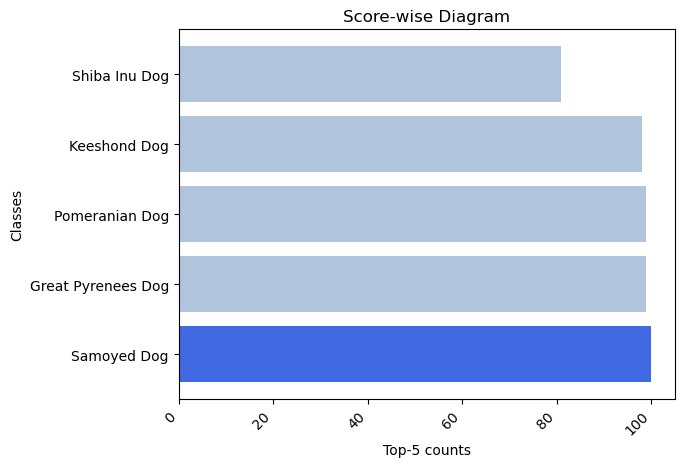

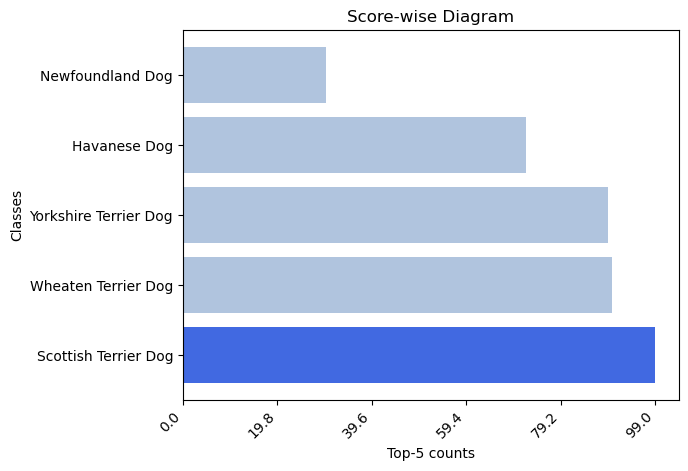

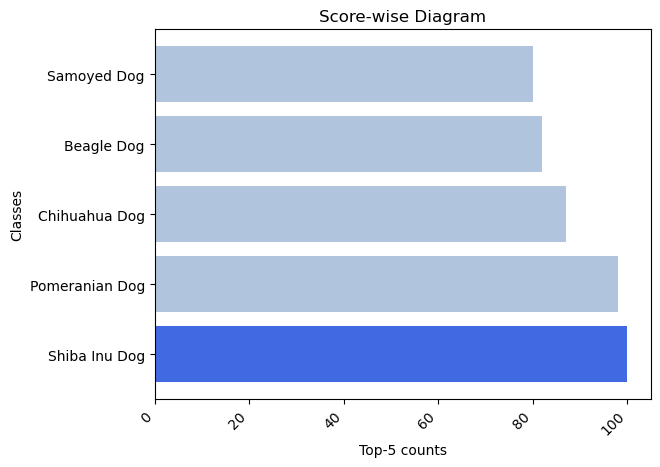

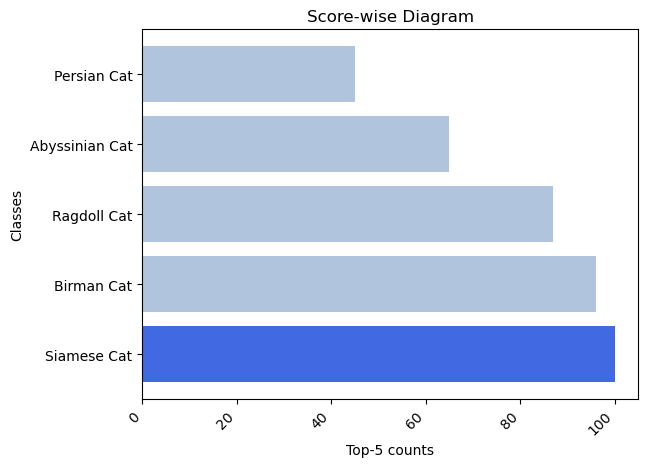

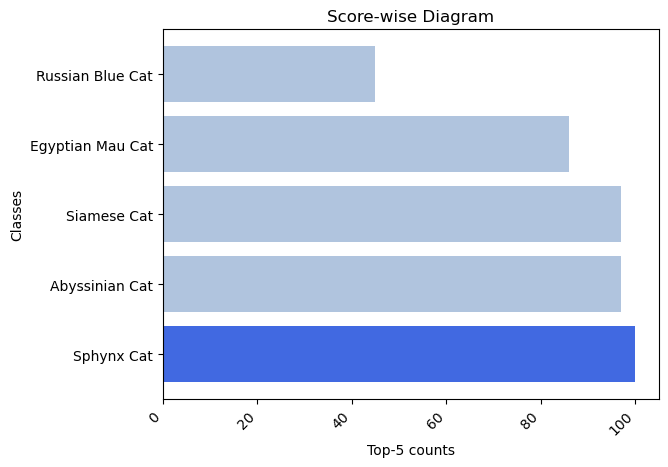

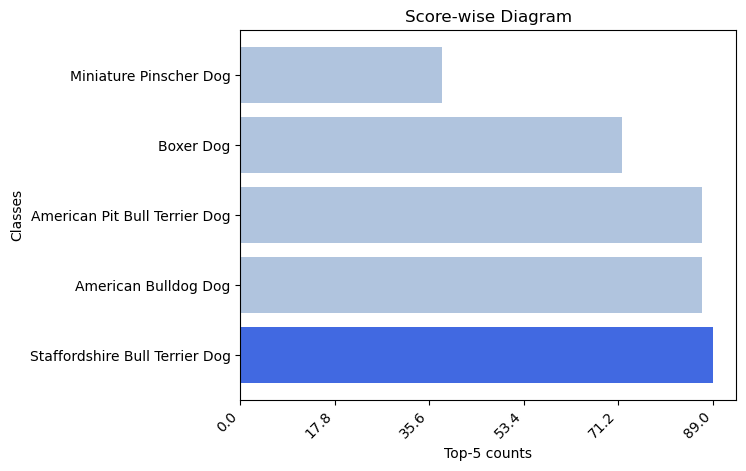

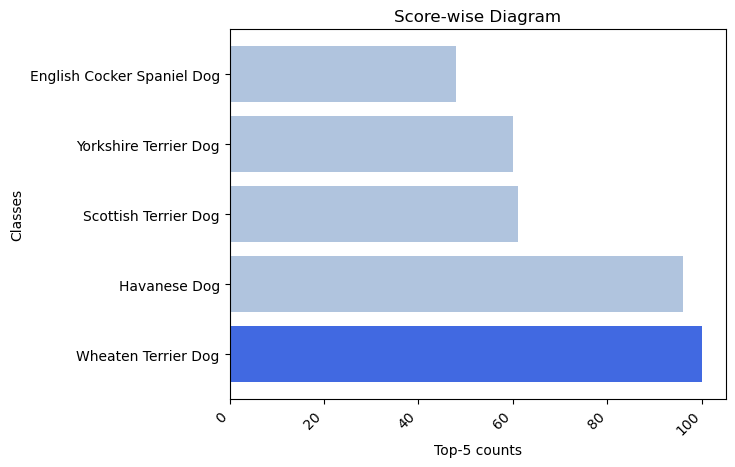

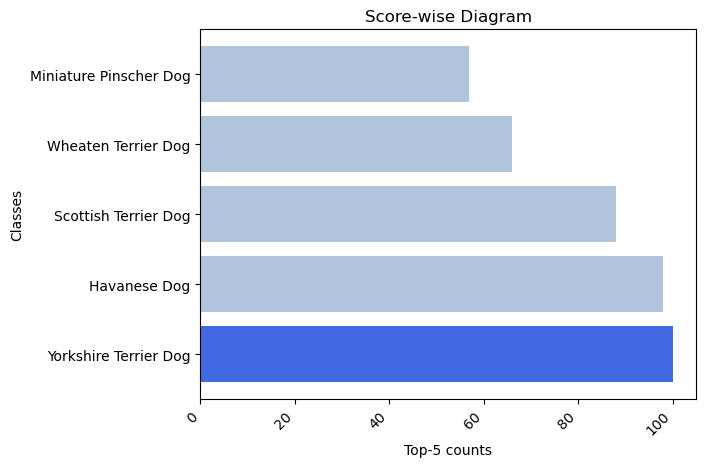

In [17]:
with open('top5.txt', 'r') as file:
    top5 = json.load(file)

for class_ in top5.keys():
    create_graph(class_, top5[class_][0:5])

In [18]:
top5[class_][0:5]

[['Yorkshire Terrier Dog', 100],
 ['Havanese Dog', 98],
 ['Scottish Terrier Dog', 88],
 ['Wheaten Terrier Dog', 66],
 ['Miniature Pinscher Dog', 57]]

# Calc Top-5 using labels

In [20]:
encodings = compute_encodings(model, oxfordpet_dataset_train.classes)
encodings_similarity = encodings @ encodings.T
topkvalues, topkidx = encodings_similarity.topk(5, dim=1)
# print(topkvalues)
idx_to_label_dict = idx_to_label(oxfordpet_dataset_train.class_to_idx)
for labels in topkidx:
    print(list(map(lambda x: idx_to_label_dict[int(x)], labels[1: 6])))

['Miniature Pinscher Dog', 'Sphynx Cat', 'Siamese Cat', 'Bengal Cat']
['American Pit Bull Terrier Dog', 'Staffordshire Bull Terrier Dog', 'Boxer Dog', 'Pug Dog']
['Staffordshire Bull Terrier Dog', 'American Bulldog Dog', 'Shiba Inu Dog', 'Boxer Dog']
['Beagle Dog', 'American Bulldog Dog', 'Shiba Inu Dog', 'American Pit Bull Terrier Dog']
['Basset Hound Dog', 'Shiba Inu Dog', 'American Bulldog Dog', 'Chihuahua Dog']
['Egyptian Mau Cat', 'Siamese Cat', 'Persian Cat', 'Sphynx Cat']
['Ragdoll Cat', 'Siamese Cat', 'Persian Cat', 'Keeshond Dog']
['Russian Blue Cat', 'Siamese Cat', 'Sphynx Cat', 'Scottish Terrier Dog']
['American Bulldog Dog', 'American Pit Bull Terrier Dog', 'Staffordshire Bull Terrier Dog', 'Pug Dog']
['Russian Blue Cat', 'Persian Cat', 'Egyptian Mau Cat', 'Siamese Cat']
['Pomeranian Dog', 'Shiba Inu Dog', 'Pug Dog', 'Persian Cat']
['British Shorthair Cat', 'Bengal Cat', 'Russian Blue Cat', 'Sphynx Cat']
['Havanese Dog', 'Chihuahua Dog', 'Pomeranian Dog', 'English Setter Do

# Result using Original Code(Aggregration method)

# Result after Combining Embeddings